In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Reading test and train data
df_trainFinal  = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage3.h5', 'train',mode='r')
df_testFinal  = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage3.h5', 'test',mode='r')

print(df_trainFinal.columns)

Index(['src', 'dst', 'ind_lnk', 'c_followers', 'c_followees', 'j_followers',
       'j_followees', 'totalFollowerSource', 'totalFollowerDestin',
       'totalFolloweeSource', 'totalFolloweeDestin', 'followerIntersect',
       'followeeIntersect', 'min_dist', 'folo_bck', 'same_cc', 'wgh_in',
       'wgh_out', 'wgh_f1', 'wgh_f2', 'wgh_f3', 'wgh_f4', 'pr_src', 'pr_dst',
       'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d'],
      dtype='object')


In [4]:
#saving the ind_link in seperate list and dropping unwanted columns
train_indLink = df_trainFinal.ind_lnk
test_indLink = df_testFinal.ind_lnk

df_trainFinal.drop(['src', 'dst','ind_lnk'], axis=1, inplace=True)
df_testFinal.drop(['src', 'dst','ind_lnk'], axis=1, inplace=True)

## a) RandomForestClassifier
Following are the parameters we have used apart from the default \\

min_samples_split: default = 2 \\
The minimum number of samples required to split an internal node:  
 
min_samples_leaf: default = 1 \\
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. \\

n_jobs: default=None \\
The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details. \\

random_state: default=None \\
Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features)

In [5]:
#Implementing Random Forest Classification for a list of estimaters - building and training the model, predicting test values and printing the f1 score
# F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account
# F1 Score = (2*TruePositives) / ((2*TruePositives) + FalseNegatives + FalsePositive) - Hybrid metric useful for unbalanced classes

estimators = [10,50,100,250,450]

train_scores = []
test_scores = []

for i in estimators:
    model = RandomForestClassifier(max_depth=5, min_samples_leaf = 52, min_samples_split = 120, n_estimators=i, n_jobs=-1, random_state = 25)
    
    model.fit(df_trainFinal, train_indLink)

    train_score = f1_score(train_indLink, model.predict(df_trainFinal ))
    test_score = f1_score(test_indLink, model.predict(df_testFinal ))

    test_scores.append(test_scores)
    train_scores.append(train_score)

    print('For estimators = ', i)
    print('Train Score: ', train_score, ' Test Score: ', test_score)


For estimators =  10
Train Score:  0.9170735831906484  Test Score:  0.9112476350417721
For estimators =  50
Train Score:  0.9205864707554021  Test Score:  0.9146692639959346
For estimators =  100
Train Score:  0.9253354911253796  Test Score:  0.9196972259810555
For estimators =  250
Train Score:  0.925742106754247  Test Score:  0.9199983113100012
For estimators =  450
Train Score:  0.9261310010696533  Test Score:  0.9203991645393362


In [6]:
depths = [2,4,10,18,22,30,40,60,80,100,120]
train_scores = []
test_scores = []

for i in depths:
    model = RandomForestClassifier(max_depth=i, min_samples_leaf = 52, min_samples_split = 120, n_estimators=115, n_jobs=-1, random_state = 25)
    
    model.fit(df_trainFinal, train_indLink)

    train_score = f1_score(train_indLink, model.predict(df_trainFinal ))
    test_score = f1_score(test_indLink, model.predict(df_testFinal ))

    test_scores.append(test_score)
    train_scores.append(train_score)

    print('For depth = ', i)
    print('Train Score: ', train_score, ' Test Score: ', test_score)


For depth =  2
Train Score:  0.905493425095244  Test Score:  0.9000165193689601
For depth =  4
Train Score:  0.9222971207608298  Test Score:  0.9169313616188814
For depth =  10
Train Score:  0.9611782907862058  Test Score:  0.9248518338852213
For depth =  18
Train Score:  0.9675857948619282  Test Score:  0.928403064230996
For depth =  22
Train Score:  0.9677432426956275  Test Score:  0.9283368421052632
For depth =  30
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321
For depth =  40
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321
For depth =  60
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321
For depth =  80
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321
For depth =  100
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321
For depth =  120
Train Score:  0.9677190564967172  Test Score:  0.9282314787516321


Finding best parameters using RandomizedSearchCV

In [7]:
param_dist = {"n_estimators": sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

model = RandomForestClassifier(random_state=25, n_jobs=-1)

model_rs = RandomizedSearchCV(model, param_distributions = param_dist, n_iter=5, cv=10, scoring='f1', random_state=25, return_train_score=True)

model_rs.fit(df_trainFinal, train_indLink)


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe44b034890>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe44b02ef90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe44c1463d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe44c0d41d0>},
                   random_state=25, return_train_score=True, scoring='f1')

In [8]:
print(model_rs.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [9]:
# Building the model with best parameters as obtained above
model = RandomForestClassifier(max_depth=14, min_samples_leaf = 28, min_samples_split = 111, n_estimators=121, n_jobs=-1, random_state = 25)

In [10]:
# Training and testing the new model 
model.fit(df_trainFinal,train_indLink)

trainPredictions = model.predict(df_trainFinal)
testPredictions = model.predict(df_testFinal)

In [11]:
print('Train f1 score', f1_score(train_indLink, trainPredictions))
print('Test f1 score', f1_score(test_indLink, testPredictions))

Train f1 score 0.9668382106641493
Test f1 score 0.9271235419435129


In [12]:
def plot_confusion_matrix(test_y, predict_y):
    # Confusion Matrix
    C = confusion_matrix(test_y, predict_y)
    # Recall Matrix - Recall = TruePositives / (TruePositive + FalseNegative) - Coverage of actual positive samples
    R =(((C.T)/(C.sum(axis=1))).T)
    # Precision Matrix - Precision = TruePositives / (TruePositive + FalsePositive) - How accurate the positive predictions are
    P =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]

    cmap=plt.cm.Greens
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Observations

Confusion Matrix: A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.

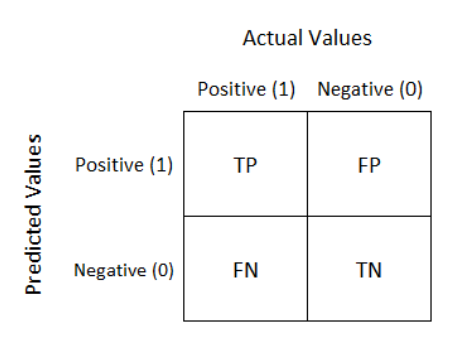

Test confusion_matrix



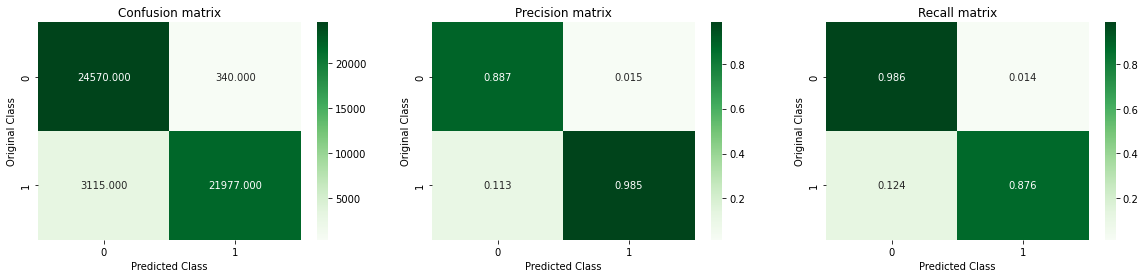

In [13]:
# print('Train confusion_matrix')
# plot_confusion_matrix(y_train,y_trainPredictions)
print('Test confusion_matrix')
print()
plot_confusion_matrix(test_indLink,testPredictions)

We see that our model classify 24570 positive points as truly positive points and 21977 negative points as truly negative in our test data.
Some points are misclassified by our model which means our model is not overfitted. We have also demonstrated Precision and Recall matrx in a heat map form for better visualization.


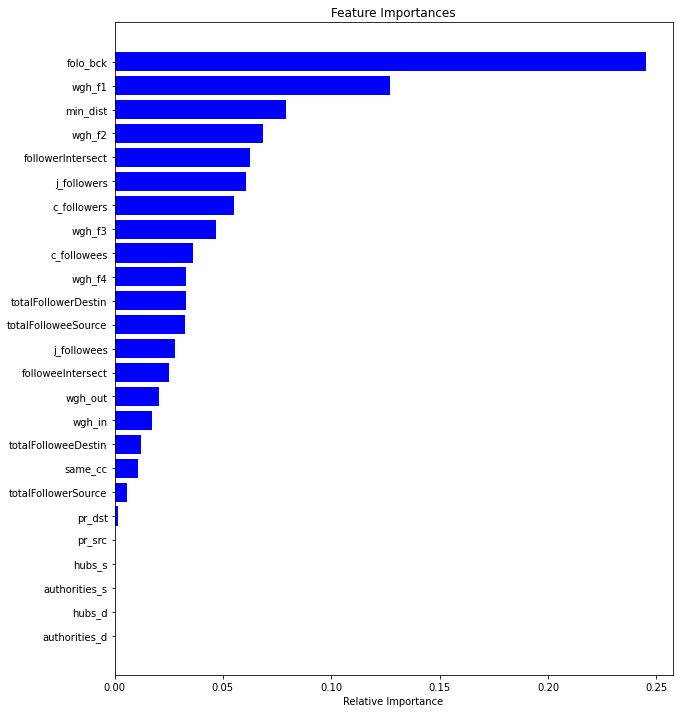

In [14]:
feature_columns = df_trainFinal.columns

feature_importance = model.feature_importances_

idx = (np.argsort(feature_importance))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(idx)), feature_importance[idx], color='b', align='center')
plt.yticks(range(len(idx)), [feature_columns[i] for i in idx])
plt.xlabel('Relative Importance')
plt.show()

The above graph displays that follow back is the most important feature for predicting if an edge. 

In [15]:
# References:

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56#:~:text=F1%20score%20is%20a%20little,low%2C%20F1%20will%20be%20low.